# HW1 due 5p Fri Jan 15 2020

This assignment will be graded on both participation and correctness (1 point each, for a total of 2 points for each sub-problem).

You are welcome (and encouraged) to:
* work together, synchronously and asynchronously, in study groups;
* use analytical and numerical computational tools -- specify the tool(s) in sourcecode and/or text;
* reuse example sourcecode and other materials provided in this course;
* consult textbooks, websites, and other publicly-available materials -- include full citation(s) with the URL and/or DOI.

Submit your homework writeup by uploading a .pdf and/or .ipynb on the Canvas Assignment.

You are welcome (and encouraged) to typeset your homework assignments rather than write them by hand.  While you could do this with LaTeX, you may find it easier to use the Colaboratory Notebook, since it is adept at embedding equations (via LaTeX syntax), matrix computations, and control system calculations.



In [2]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger, so this command turns the debugger OFF
%pdb off

# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op
# SciPy module that implements many of the routines in ctrl
from scipy import signal as sig

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# animation
from matplotlib import animation as ani
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym

# os = operating system; access OS-level commands
# e.g. create directory, delete file, execute command
# (more platform-independent than "!")
import os

# test whether this is a Colaboratory or Jupyter notebook
try:
  import google.colab
  COLAB = True
  print('Colaboratory Notebook')
except:
  COLAB = False
  print('Jupyter Notebook')

  # Colab notebook
if COLAB:  
  # render SymPy equations nicely in Colaboratory Notebook
  def colab_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
  
  sym.init_printing(use_latex="mathjax",latex_printer=colab_latex_printer)

# Jupyter notebook
else:
  init_printing(use_latex='mathjax')

def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(t,x,u) 

  input:
    f : T x X x U --> X - vector field
      T - time space (subset of real numbers)
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

Automatic pdb calling has been turned OFF
Colaboratory Notebook


# 0. Sam; he/him

a. Approximately how many hours did you spend on this assignment?

***Sam:*** $\approx 2$ hours.

b. Were there specific problems that took much longer than others?

***Sam:*** getting the chain rule right in (2.) took a couple tries :)

c. What class meeting(s) did you participate in this week?

***Sam:*** all :)

d. What timezone(s) were you working in this week?

***Sam:*** Seattle time

# 1. trajectories, flows, and simulations

Consider the following simplified CT-DE model for an inverted pendulum, which consists of a massless rod of length $\ell$ with a point mass $m$ affixed to one end and a rotational joint affixed to the other end,
$$
m \ell^2 \ddot{q} = m g \ell \sin q - \alpha\dot{q} + \ell u \cos q,
$$
where
$q$ is the pendulum angle,
$\alpha > 0$ is a coefficient of rotational friction,
and $u$ is the horizontal acceleration of the pivot point.


In [3]:
t, m, g, l, q, dq, a, u = sym.symbols(r't, m, g, \ell, q, \dot{q}, \alpha, u')
t, m, g, l, q, dq, a, u

(t, m, g, \ell, q, \dot{q}, \alpha, u)

In [4]:
ddq = ( m*g*l*sym.sin(q) - a*dq + l*u*sym.cos(q)) / (m*l**2)
ddq

-\alpha⋅\dot{q} + \ell⋅g⋅m⋅sin(q) + \ell⋅u⋅cos(q)
─────────────────────────────────────────────────
                         2                       
                     \ell ⋅m                     

In [5]:
f = sym.Matrix([[dq],[ddq]])
f

⎡                     \dot{q}                     ⎤
⎢                                                 ⎥
⎢-\alpha⋅\dot{q} + \ell⋅g⋅m⋅sin(q) + \ell⋅u⋅cos(q)⎥
⎢─────────────────────────────────────────────────⎥
⎢                         2                       ⎥
⎣                     \ell ⋅m                     ⎦


a. Show that $q \equiv 0$, $q \equiv \pi$ define trajectories for the CT-DE when $u = 0$.


***Solution:*** both of these putative trajectories are constant, so it suffices to check that they are equilibria (i.e. $f((\pm\pi,0),0) = 0$).

In [6]:
# q = 0
q0 = 0
dq0 = 0
u0 = 0
f.subs({q:q0,dq:dq0,u:u0})

⎡0⎤
⎢ ⎥
⎣0⎦

In [7]:
# q = pi
q0 = sym.pi
dq0 = 0
u0 = 0
f.subs({q:q0,dq:dq0,u:u0})

⎡0⎤
⎢ ⎥
⎣0⎦


b. Given $q_0 \neq 0$, find $u_0$ such that $q \equiv q_0$ defines a trajectory for the CT-DE; are there any limits on $q_0$?


***Solution:*** since the putative trajectory is again an equilibrium, it suffices to find $u_0$ such that $f((q_0,0),u_0) = 0$.

In [8]:
sym.solve(f.subs({dq:0}),u)

{u: -g⋅m⋅tan(q)}

This solution is only valid when $q_0 \neq (2 k - 1) \frac{\pi}{2}$ where $k\in\mathbb{N}$ -- looking back at the DE, this makes sense:  as $\cos q \rightarrow 0$ the control input would need to grow unbounded, ($u\rightarrow\infty$) to maintain equilibrium.


c. Determine the input $u$ needed to make the constant-velocity motion $q(t) = t$ a trajectory of the CT-DE; is there a limit on the time horizon $t$?


***Solution:*** the trajectory isn't constant, but it does have constant velocity, which requires zero acceleration, so it suffices to solve $\ddot{q}(q,\dot{q},u) = 0$ for $u$.

In [9]:
sym.solve(f,u)

⎧   \alpha⋅\dot{q}             ⎫
⎨u: ────────────── - g⋅m⋅tan(q)⎬
⎩    \ell⋅cos(q)               ⎭

This solution is only valid when $q_0 \neq (2 k - 1) \frac{\pi}{2}$ where $k\in\mathbb{N}$, so the time horizon is limited to $t < \pi/2$ (the trajectory starts at $q(0) = 0$ and has $\dot{q} \equiv 1$).


In the following subproblems, use computational tools and present your results using plots and other visualizations (i.e. don't just provide numeric output).  You can use any positive parameter values of your choosing; I suggest $m = 1$, $\ell = 0.5$, $g = 9.81$, $\alpha = 0.25$.

d. Use numerical simulations to verify your answers to (a.), (b.), (c.).


In [10]:
p = {m:1,l:.5,g:9.81,a:.25}
f_ = sym.lambdify([(q,dq),u],f.subs(p))
u_b = sym.lambdify([(q,dq)],u.subs(sym.solve(f.subs({dq:0}),u)).subs(p))
u_c = sym.lambdify([(q,dq)],u.subs(sym.solve(f,u)).subs(p))

In [11]:
# (a.) q = 0
q0 = 0
dq0 = 0
u0 = 0
f_((q0,dq0),u0)

array([[0.],
       [0.]])

In [12]:
# (a.) q = pi
q0 = np.pi
dq0 = 0
u0 = 0
f_((q0,dq0),u0)

array([[0.000e+00],
       [2.403e-15]])

In [13]:
# (b.) q_0 != 0
q0 = np.pi*(np.random.rand() - .5)
dq0 = 0
u0 = u_b((q0,dq0))
print('q0 = %0.1f, u0 = %0.1f'%(q0,u0))
print('f((q0,dq0),u0) =',f_((q0,dq0),u0).flatten())

q0 = -1.0, u0 = 14.1
f((q0,dq0),u0) = [ 0.000e+00 -3.553e-15]


In [14]:
# (c.) q(t) = t
dq0 = 1
for q0 in np.linspace(0,np.pi/2,endpoint=False):
  # if this doesn't raise error, then the acceleration is zero for q in [0,pi/2]
  assert np.allclose(f_((q0,dq0),u_c((q0,dq0)))[1],0)


e. Use numerical simulations to determine what happens to trajectories that are initialized close, but not exactly at, the trajectories from (a.), (b.), (c.).


In [15]:
f_a = lambda t,x : f_(x,0).flatten()
f_b = lambda t,x : f_(x,u_b(x)).flatten()
f_c = lambda t,x : f_(x,u_c(x)).flatten()

t = np.pi/4

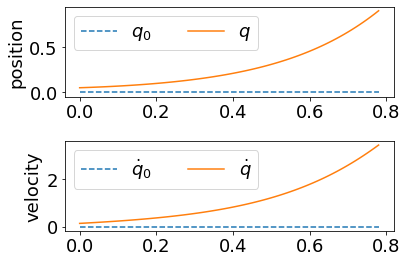

In [16]:
# (a.) q = 0
q0 = 0
dq0 = 0

x0 = np.asarray([q0,dq0])
t_,x0_ = numerical_simulation(f_a,t,x0,dt=1e-2)

x0 = np.asarray([q0,dq0]) + np.random.randn(2)*1e-1
t_,x_ = numerical_simulation(f_a,t,x0,dt=1e-2)

plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,x0_[:,0],'--',label=r'$q_0$')
plt.plot(t_,x_[:,0],label=r'$q$')
plt.ylabel('position')
plt.legend(ncol=2)

plt.subplot(2,1,2)
plt.plot(t_,x0_[:,1],'--',label=r'$\dot{q}_0$')
plt.plot(t_,x_[:,1],label=r'$\dot{q}$')
plt.ylabel('velocity')
plt.legend(ncol=2)

plt.tight_layout()

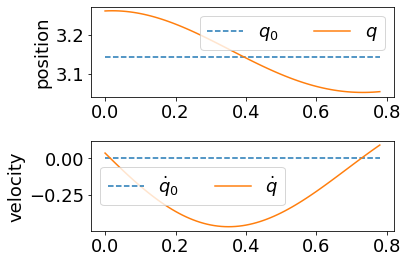

In [17]:
# (a.) q = pi
q0 = np.pi
dq0 = 0

x0 = np.asarray([q0,dq0])
t_,x0_ = numerical_simulation(f_a,t,x0,dt=1e-2)

x0 = np.asarray([q0,dq0]) + np.random.randn(2)*1e-1
t_,x_ = numerical_simulation(f_a,t,x0,dt=1e-2)

plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,x0_[:,0],'--',label=r'$q_0$')
plt.plot(t_,x_[:,0],label=r'$q$')
plt.ylabel('position')
plt.legend(ncol=2)

plt.subplot(2,1,2)
plt.plot(t_,x0_[:,1],'--',label=r'$\dot{q}_0$')
plt.plot(t_,x_[:,1],label=r'$\dot{q}$')
plt.ylabel('velocity')
plt.legend(ncol=2)

plt.tight_layout()

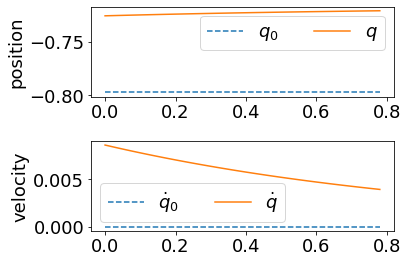

In [18]:
# (b.) q0 != 0
q0 = np.pi*(np.random.rand() - .5)
dq0 = 0

x0 = np.asarray([q0,dq0])
t_,x0_ = numerical_simulation(f_b,t,x0,dt=1e-2)

x0 = np.asarray([q0,dq0]) + np.random.randn(2)*1e-1
t_,x_ = numerical_simulation(f_b,t,x0,dt=1e-2)

plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,x0_[:,0],'--',label=r'$q_0$')
plt.plot(t_,x_[:,0],label=r'$q$')
plt.ylabel('position')
plt.legend(ncol=2)

plt.subplot(2,1,2)
plt.plot(t_,x0_[:,1],'--',label=r'$\dot{q}_0$')
plt.plot(t_,x_[:,1],label=r'$\dot{q}$')
plt.ylabel('velocity')
plt.legend(ncol=2)

plt.tight_layout()

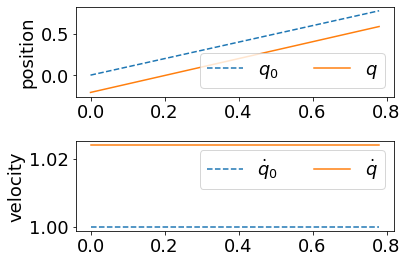

In [19]:
# (c.) q(t) = t
q0 = 0
dq0 = 1

x0 = np.asarray([q0,dq0])
t_,x0_ = numerical_simulation(f_c,t,x0,dt=1e-2)

x0 = np.asarray([q0,dq0]) + np.random.randn(2)*1e-1
t_,x_ = numerical_simulation(f_c,t,x0,dt=1e-2)

plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,x0_[:,0],'--',label=r'$q_0$')
plt.plot(t_,x_[:,0],label=r'$q$')
plt.ylabel('position')
plt.legend(ncol=2)

plt.subplot(2,1,2)
plt.plot(t_,x0_[:,1],'--',label=r'$\dot{q}_0$')
plt.plot(t_,x_[:,1],label=r'$\dot{q}$')
plt.ylabel('velocity')
plt.legend(ncol=2)

plt.tight_layout()

# 2. linearization

Consider the CT-DE model for an inverted pendulum from (1.); solve the following problems analytically (i.e. not using numeric parameter values), that is, compute the derivative of the CT-DE and evaluate along the trajectories indicated.

***First*** let's compute the derivative symbolically.

In [20]:
Dxf = sym.Matrix.hstack(sym.diff(f,q),sym.diff(f,dq))
Dxf

⎡               0                    1    ⎤
⎢                                         ⎥
⎢\ell⋅g⋅m⋅cos(q) - \ell⋅u⋅sin(q)  -\alpha ⎥
⎢───────────────────────────────  ────────⎥
⎢                2                    2   ⎥
⎣            \ell ⋅m              \ell ⋅m ⎦

In [21]:
Duf = sym.diff(f,u)
Duf

⎡  0   ⎤
⎢      ⎥
⎢cos(q)⎥
⎢──────⎥
⎣\ell⋅m⎦

a. Linearize this system around the equilibrium $q \equiv 0$ from (1a.).

***Solution:*** we can obtain the desired linearization by evaluating the symbolic derivative at the specified equilibrium:

In [34]:
Dxf.subs({q:0,dq:0,u:0})

⎡ 0       1    ⎤
⎢              ⎥
⎢ g    -\alpha ⎥
⎢────  ────────⎥
⎢\ell      2   ⎥
⎣      \ell ⋅m ⎦


b. Linearize this system around the equilibrium $q \equiv \pi$ from (1a.); how does the answer differ from (a.)?


In [23]:
Dxf.subs({q:-sym.pi,dq:0,u:0})

⎡ 0       1    ⎤
⎢              ⎥
⎢-g    -\alpha ⎥
⎢────  ────────⎥
⎢\ell      2   ⎥
⎣      \ell ⋅m ⎦

The only difference from (a.) is the sign of the lower-left entry.  (We will later see that this sign change has significance for *stability* of the equilibrium.)


c. Linearize this system around the equilibrium $q_0, u_0 \neq 0$ from (1b.).


***Solution:*** there are two valid ways to interpret the question:  either $u \equiv u_0$ regardless of the system state, or $u$ is determined as the function of $q$ that ensures $\ddot{q} = 0$ when $\dot{q} = 0$ -- the solution below is for the second interpretation.

The control law must be taken into account to obtain the correct linearization -- there are two primary ways to do this:  substitution or chain rule.

To use substitution, we first define the control law, then substitute that into the expression for $f$, before computing the derivative of $f$.

In [24]:
ub = u.subs(sym.solve(f.subs({dq:0}),u))
ub

-g⋅m⋅tan(q)

In [25]:
fu = f.subs({u:ub})
sym.simplify(sym.Matrix.hstack(sym.diff(fu,q),sym.diff(fu,dq)))

⎡0     1    ⎤
⎢           ⎥
⎢   -\alpha ⎥
⎢0  ────────⎥
⎢       2   ⎥
⎣   \ell ⋅m ⎦

To apply the chain rule, we differentiate the control law, then combine that with the derivatives of $f$ with respect to state and input via
$$ D_x \left[ f(x,u(x)) \right] = D_x f(x,u(x)) + D_u f(x,u(x)) \cdot D_x u(x) $$

In [26]:
Dub = sym.Matrix([[sym.diff(ub,q),sym.diff(ub,dq)]])
Dub

⎡     ⎛   2       ⎞   ⎤
⎣-g⋅m⋅⎝tan (q) + 1⎠  0⎦

In [27]:
sym.simplify(Dxf.subs({u:ub}) + Duf*Dub)

⎡0     1    ⎤
⎢           ⎥
⎢   -\alpha ⎥
⎢0  ────────⎥
⎢       2   ⎥
⎣   \ell ⋅m ⎦

Both methods give the same result :)


d. Linearize this system along the nonequilibrium trajectory from (1c.).

***Solution:*** there are two valid ways to interpret the question:  either $u$ is purely a function of time, or $u$ is a function of state that ensures $\ddot{q} = 0$ -- the solution below is for the second interpretation.

The control law must be taken into account to obtain the correct linearization -- there are two primary ways to do this:  substitution or chain rule.

To use substitution, we first define the control law, then substitute that into the expression for $f$, before computing the derivative of $f$.

In [28]:
uc = u.subs(sym.solve(f,u))
uc

\alpha⋅\dot{q}             
────────────── - g⋅m⋅tan(q)
 \ell⋅cos(q)               

In [29]:
fu = f.subs({u:uc})
sym.simplify(sym.Matrix.hstack(sym.diff(fu,q),sym.diff(fu,dq)))

⎡0  1⎤
⎢    ⎥
⎣0  0⎦

To apply the chain rule, we differentiate the control law, then combine that with the derivatives of $f$ with respect to state and input via
$$ D_x \left[ f(x,u(x)) \right] = D_x f(x,u(x)) + D_u f(x,u(x)) \cdot D_x u(x) $$

In [30]:
Duc = sym.Matrix([[sym.diff(uc,q),sym.diff(uc,dq)]])
Duc

⎡\alpha⋅\dot{q}⋅sin(q)       ⎛   2       ⎞     \alpha  ⎤
⎢───────────────────── - g⋅m⋅⎝tan (q) + 1⎠  ───────────⎥
⎢             2                             \ell⋅cos(q)⎥
⎣     \ell⋅cos (q)                                     ⎦

In [31]:
sym.simplify(Dxf.subs({u:uc}) + Duf*Duc)

⎡0  1⎤
⎢    ⎥
⎣0  0⎦

Both methods give the same result :)

# 3. feedback "linearization"

The dynamics of a fully-actuated unconstrained mechanical system have the form
$$ M(q) \ddot{q} + C(q,\dot{q})\dot{q} + V(q) = u $$
where:
$M(q)$ is the *mass matrix*;
$C(q,\dot{q})\dot{q}$ are *Coriolis forces*;
$V(q)$ is *potential forces*;
and
$u$ is a vector of generalized forces and torques (i.e. a [wrench](https://en.wikipedia.org/wiki/Screw_theory#Wrench_2)).



a. Assuming $u$ is a control input, determine a state-feedback law such that $\ddot{q} = v$ for a given $v$.

***Solution:*** $u((q,\dot{q}),v) = M(q) v + C(q,\dot{q})\dot{q} + V(q)$.



***Note:*** this is an example of a controller that performs "*feedback linearization*", that is, it is a nonlinear controller that renders a nonlinear system's closed-loop dynamics *exactly* linear -- this should not be confused with the "linearization" procedure applied in (2.) that produces a linear system that approximates the original nonlinear system.


b. Apply the controller from (a.) to the pendulum from (1.).

Recalling that the pendulum's dynamics can be written as
$$
m \ell^2 \ddot{q} + \alpha\dot{q} - m g \ell \sin q = \ell u \cos q,
$$
we find that
$$
u((q,\dot{q}),v) = \frac{1}{\ell\cos q}\left( m\ell^2 v + \alpha\dot{q} - mg\ell\sin q \right).
$$



In the following subproblems, use computational tools and present your results using plots and other visualizations (i.e. don't just provide numeric output).

Now suppose $v = -K_P (q - q_0) - K_D \dot{q}$ for some symmetric positive-definite $K_P$, $K_D$ and reference configuration $q_0$ (i.e. $v$ is used to apply a generalized proportional-derivative controller).



c. Apply the controller from (b.) together with the proportional-derivative controller defined above to the pendulum; you can choose the parameter values and reference configuration.


In [ ]:
v = sym.symbols(r'v')
v

v

In [ ]:
u_fl = (m*l**2*v + a*dq - m*g*l*sym.sin(q)) / (l*sym.cos(q))
u_fl

                     2                      
\alpha⋅\dot{q} + \ell ⋅m⋅v - \ell⋅g⋅m⋅sin(q)
────────────────────────────────────────────
                \ell⋅cos(q)                 

In [ ]:
f_fl = sym.simplify(f.subs({u:u_fl}))

In [ ]:
k_P,k_D,q_0 = sym.symbols(r'k_P,k_D,q_0')
k_P,k_D,q_0

(k_P, k_D, q₀)

In [ ]:
f_fl.subs({v:-k_P*(q - q_0) - k_D*dq})

⎡          \dot{q}          ⎤
⎢                           ⎥
⎣-\dot{q}⋅k_D - k_P⋅(q - q₀)⎦